In [36]:
# Import libaries and illustris library
import sys
sys.path.append("/Users/alex/Documents/Research/Astro/git_rep/Modules")
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import gridspec
import random
from numba import jit

import illustris_python as il
import subroutines.tree_functions as tf
import subroutines.orbits as of
import illustrisAPI.iApi as iapi
iapi.headers['api-key']='4bf1a1e26a9a0777777dd7fa074e2e1f'
hubble = 0.704

In [27]:
plt.style.use('default')
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=15
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7

yor__cmap = mpl.cm.get_cmap('YlOrRd');
vir__cmap = mpl.cm.get_cmap('viridis');
greys__cmap = mpl.cm.get_cmap('Greys');
tab_cmap = mpl.cm.get_cmap('tab20b');

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
def maskEllips(whichSnap):
    return (galData[whichSnap][:,14]<0.5);
def maskMass(whichSnap, mass_low, mass_high=50000):
    return ( (mass_high>galData[whichSnap][:,2]) & (galData[whichSnap][:,2]>mass_low) );
def maskMass_data(data, mass_low, mass_high=50000):
    return ( (mass_high>data) & (data>mass_low) );
def maskWeb(whichSnap, webValue):
    return (webData[whichSnap][:,17]==webValue);
def maskWeb_ellip(whichSnap, webValue):
    return (webData_ellip[whichSnap][:,17]==webValue);

In [31]:
#load data
snaps=[135,116,103,85]
webData = []
for i in snaps:
    # 0:HaloNumber, 1:SubhaloNumber, 2-4:SubhaloPosition x,y,z, 5: Index of nearest critical point, 6: absolute distance to crit., 7-9: nearest critical point coordinates, 
    # 10: Index of nearest filament, 11:absolute distance to filament, 12-14: nearest filament coordinates, 15: cos(theta) 16:sin(theta) 17:cluster(1) fil(0) nothing(-1)
    # 17: cluster=1, filament=0, none=-1
    webData.append(np.genfromtxt('Data/WebData/galaxy_web_data.'+str(i)+'.txt'))
    
#load all galaxy data
allgalData = []
for i in range (135,84,-1):
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    allgalData.append(np.genfromtxt('Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

allgalData_ellip = []; allgalData_disk = [];
for i in range(0,51):
    allgalData_ellip.append(allgalData[i][allgalData[i][:,14]<0.5]);
    allgalData_disk.append(allgalData[i][allgalData[i][:,14]>0.5]);

In [33]:
# load quantities for all subhalos
pathToDir='/Users/alex/Documents/Research/Astro/git_rep/Data/SubhaloData/'
positions = []
masses = []
stellar_masses = []
velocities= []
subhalo_parent= []
half_mass_rad= []
for snapNum in np.arange(135,84,-1):
    positions.append(iapi.getSubhaloField('SubhaloPos',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloPos.'+str(snapNum)))
    masses.append(iapi.getSubhaloField('SubhaloMassType',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloMassType.'+str(snapNum))[:,1])
    velocities.append(iapi.getSubhaloField('SubhaloVel',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloVel.'+str(snapNum)))
    half_mass_rad.append(iapi.getSubhaloField('SubhaloHalfmassRad',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloHalfmassRad.'+str(snapNum)))
    stellar_masses.append(iapi.getSubhaloField('SubhaloMassType',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloMassType.'+str(snapNum))[:,4])

In [40]:
# load data
# load fast ellpitical galaxies that spun down without major mergers
noMaj_nsnap = np.genfromtxt('Data/CalcData/noMajors_nsub.txt').astype(int)
subhalo_numbers = np.genfromtxt('Data/CalcData/subhalo_numbers.txt').astype(int)

In [52]:
def find_gal_in_rad(pos_data, mass_data, vel_data, gal_mass, gal_vel, rad_data, index_of_gal, rad = 1000, mass=0.1, orbit_steps=100):
    gal_position = pos_data[index_of_gal,:]
    gal_rad = rad_data[index_of_gal]
    pos_mask = (((gal_position[0]+rad)>pos_data[:,0]) & (pos_data[:,0]>(gal_position[0]-rad)) & 
                ((gal_position[1]+rad)>pos_data[:,1]) & (pos_data[:,1]>(gal_position[1]-rad)) &
                ((gal_position[2]+rad)>pos_data[:,2]) & (pos_data[:,2]>(gal_position[2]-rad)) & 
                 (gal_position[0]!=pos_data[:,0]) & 
                 (gal_position[1]!=pos_data[:,1]) & 
                 (gal_position[2]!=pos_data[:,2])
               )
    mass_mask = mass_data[:]>mass
    nearby_pos =  pos_data[pos_mask & mass_mask]-gal_position
    nearby_mass = mass_data[pos_mask & mass_mask]
    nearby_vel =  vel_data[pos_mask & mass_mask]-gal_vel
    nearby_rad =  rad_data[pos_mask & mass_mask]

    orbits = np.zeros((nearby_pos.shape[0], orbit_steps,3))
    impact_parameters = np.zeros((nearby_pos.shape[0]))
    for i in range(0,nearby_pos.shape[0]):
        orbit_params = integrate_orbits(nearby_pos[i], nearby_vel[i], nearby_mass[i], gal_mass, gal_rad, 44985, orbit_steps)[:,0:3]
        orbits[i,:,:] = orbit_params
        #impact_parameters[i] = orbit_params[1]
    
    return nearby_pos, nearby_mass, nearby_vel, nearby_rad, orbits, impact_parameters

In [59]:
def orbit_energy(part_pos, part_vel, part_mass, gal_mass, gal_rad, grav_const):
    rad_vector_length = np.linalg.norm(part_pos)
    vel_vector_length = np.linalg.norm(part_vel)
    
    gal_mass = nfw_profile(rad_vector_length, gal_mass, gal_rad)
    
    grav_energy = -(grav_const * gal_mass * part_mass)/(rad_vector_length)
    kin_energy = 0.5 * part_mass * (vel_vector_length)**2
    
    return kin_energy+grav_energy

In [56]:
def integrate_orbits(part_pos, part_vel, part_mass, gal_mass, gal_rad, grav_const, steps = 20, steps_per_snapshot = 10):
    # time between snapshots median: 0.161, mean: 0.155, std: 0.0294 Gyrs, one step is 1/10 of a snapshot
    time_steps = steps
    output = np.zeros((time_steps,6))
    delta_t = 0.16/steps_per_snapshot
    pos_vector = part_pos
    vel_vector = part_vel
    
    for i in range(0, steps):
        rad_vector = pos_vector
        rad_vector_length = np.linalg.norm(rad_vector)
        rad_vector_unit = -rad_vector/rad_vector_length
        
        gal_mass = nfw_profile(rad_vector_length, gal_mass, gal_rad)
        
        acc_vector = (grav_const * gal_mass * rad_vector_unit)/(rad_vector_length**2)
        vel_vector = acc_vector * delta_t+vel_vector
        pos_vector = vel_vector * delta_t+pos_vector
        
        output[i,0:3] = pos_vector
        output[i,3:7] = vel_vector
        
    return output

def nfw_profile(r, m_200, r_200, c=12):
    r_s = r_200/c
    c_term = np.log(1+c)-(c/(1+c))
    rho_0 = m_200/(4*np.pi*c_term*r_s**3)
    return m_200*(np.log((r_s+r)/r_s)-(r/(r_s+r)))/c_term

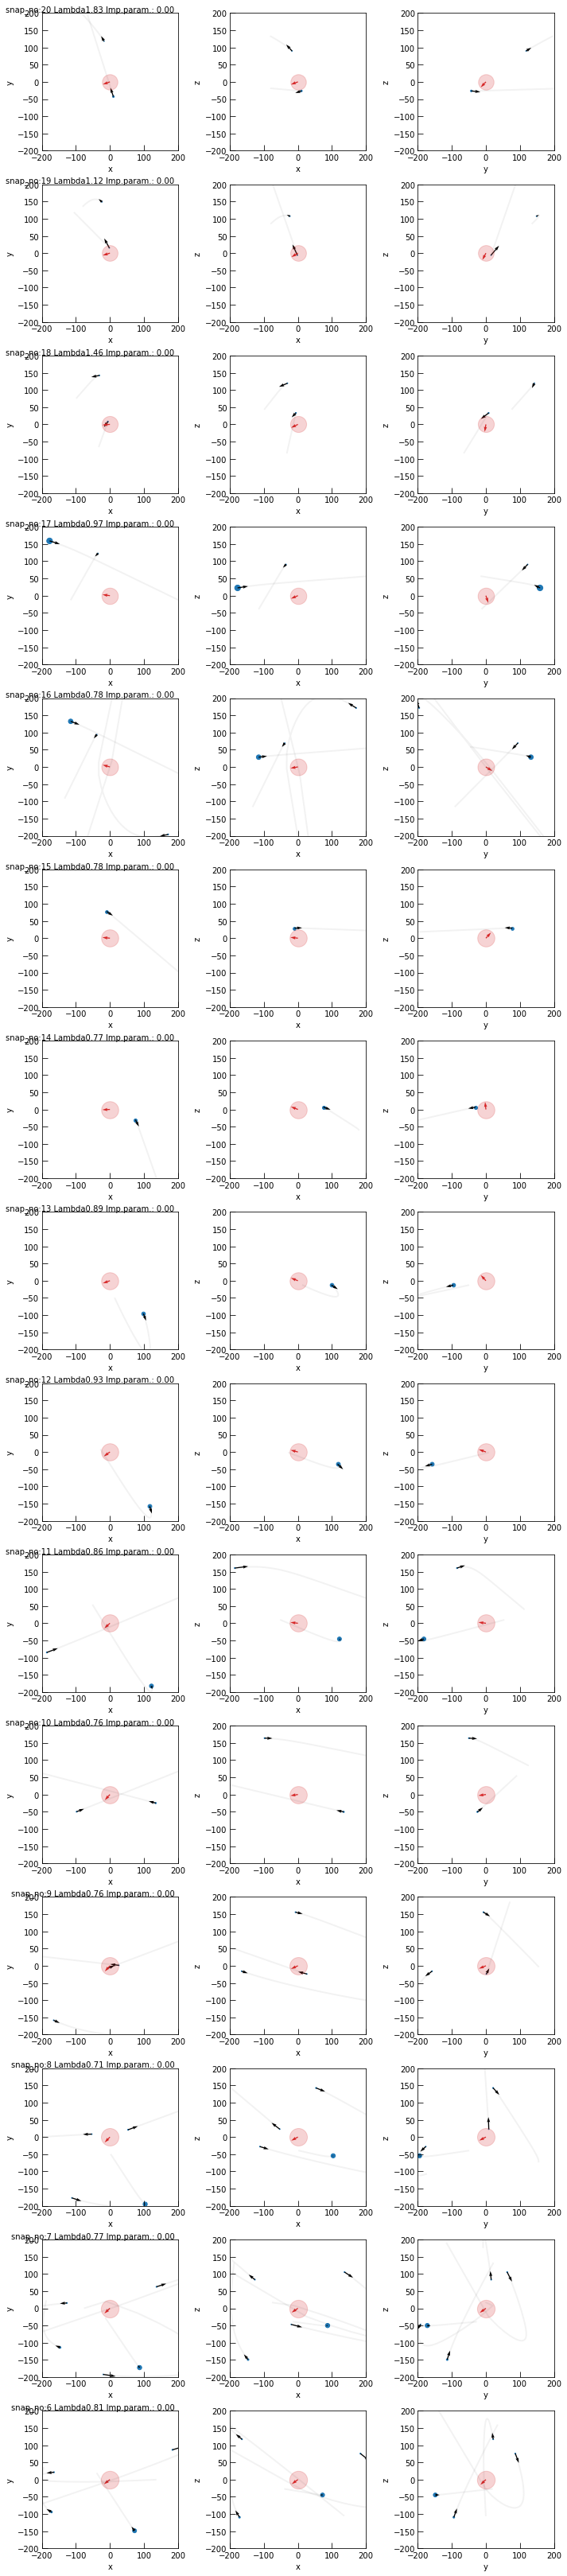

In [58]:
galaxy_number = 14
z_back_start = 30 # counts snapshots from z=1 forward in time
z_back_end = 45
size = 200
fig = plt.figure(figsize=(10, 3*(z_back_end-z_back_start))); gs=gridspec.GridSpec(z_back_end-z_back_start,3); count =0;

for i in  np.arange(50-z_back_start,50-z_back_end,-1):
    gal_mass = masses[i][subhalo_numbers[galaxy_number][i]]
    gal_vel = velocities[i][subhalo_numbers[galaxy_number][i]]
    gal_ang_mom = allgalData[i][np.argwhere(allgalData[i][:,1]==subhalo_numbers[galaxy_number][i])[0][0],11:14]
    gal_lambda = allgalData[i][np.argwhere(allgalData[i][:,1]==subhalo_numbers[galaxy_number][i])[0][0],16]
    gal_half_mass_rad = (half_mass_rad[i]/hubble)[subhalo_numbers[galaxy_number][i]]

    nearby_gal = find_gal_in_rad(positions[i]/hubble, (masses[i])/hubble, velocities[i], gal_mass, gal_vel, half_mass_rad[i]/hubble, subhalo_numbers[galaxy_number][i], size,  0.5, 60)
    nearby_pos = nearby_gal[0]
    nearby_mass = nearby_gal[1]
    nearby_vel = nearby_gal[2]
    nearby_rad = nearby_gal[3]
    orbits= nearby_gal[4]
    impact_param= nearby_gal[5]
    
    if impact_param.size:
        min_param = min(impact_param)
    else:
        min_param = np.NAN

    ax1 = plt.subplot(gs[count,0]); ax2 = plt.subplot(gs[count,1]); ax3 = plt.subplot(gs[count,2]); 
    ax1.scatter(nearby_pos[:,0], nearby_pos[:,1], s=nearby_mass)#,c= yor__cmap(color_map))
    for j in range(0,nearby_pos.shape[0]):
            ax1.plot(orbits[j,:,0], orbits[j,:,1], c='k', alpha=0.05 )
    ax1.quiver(nearby_pos[:,0], nearby_pos[:,1], nearby_vel[:,0], nearby_vel[:,1])
    ax1.set_xlabel('x'),ax1.set_ylabel('y')

    ax1.scatter(0,0 ,c='C3', s=gal_mass, alpha=0.2); 
    ax1.set_xlim([-size,size]); ax1.set_ylim([-size,size])
    ax1.quiver(0,0,gal_ang_mom[0],gal_ang_mom[1], facecolor='C3')
    
    ax2.scatter(nearby_pos[:,0], nearby_pos[:,2], s=nearby_mass)#, c =yor__cmap(color_map))
    ax2.quiver(nearby_pos[:,0], nearby_pos[:,2], nearby_vel[:,0], nearby_vel[:,2])

    ax2.scatter(0,0 ,c='C3', s=gal_mass, alpha=0.2);  ax2.set_xlim([-size,size]); ax2.set_ylim([-size,size])
    ax2.quiver(0,0,gal_ang_mom[0],gal_ang_mom[2], facecolor='C3')
    for j in range(0,nearby_pos.shape[0]):
           ax2.plot(orbits[j,:,0], orbits[j,:,2], c='k', alpha=0.05 )
    ax2.set_xlabel('x'),ax2.set_ylabel('z')
    
    ax3.scatter(nearby_pos[:,1], nearby_pos[:,2], s=nearby_mass)#, c= yor__cmap(color_map))
    ax3.quiver(nearby_pos[:,1], nearby_pos[:,2], nearby_vel[:,1], nearby_vel[:,2])
    ax3.scatter(0,0 ,c='C3', s=gal_mass, alpha=0.2);  ax3.set_xlim([-size,size]); ax3.set_ylim([-size,size])
    ax3.quiver(0,0,gal_ang_mom[1],gal_ang_mom[2], facecolor='C3')
    ax3.set_xlabel('y'),ax3.set_ylabel('z')
    for j in range(0,nearby_pos.shape[0]):
            ax3.plot(orbits[j,:,1], orbits[j,:,2], c='k', alpha=0.05 )

    
    ax1.text(190,205, 'snap_no:'+str(i)+' Lambda'+str('%.2f'%(gal_lambda))+' Imp.param.: '+str('%.2f'%min_param) ,fontsize=10, ha='right');
    count=count+1
    #print(nearby_mass)
plt.tight_layout()
plt.show()
#fig.savefig('../../Plots/NoMajs_gal_'+str(galaxy_number)+'.pdf', format='pdf')